In [25]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
model.invoke("안녕! 수요일 밤에 공부하러 왔어.")

AIMessage(content='안녕하세요! 수요일 밤에 공부하러 오셨군요. 어떤 과목이나 주제를 공부하고 계신가요? 도움이 필요하시면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 21, 'total_tokens': 57, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CBhWccLf9Jw7EUZFgpbrtjRzu2J0m', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b1f30104-795a-47fd-a843-f7b6be580ba8-0', usage_metadata={'input_tokens': 21, 'output_tokens': 36, 'total_tokens': 57, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [26]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[str], add_messages]


graph_builder = StateGraph(State)

In [27]:
from langchain_core.tools import tool
from datetime import datetime
import pytz
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

import bs4
from langchain_community.document_loaders import WebBaseLoader


@tool
def get_current_time(timezone: str = "Asia/Seoul", location: str = "서울") -> str:
    """
    현재 시간을 조회합니다.

    Args:
        timezone (str): 타임존
        location (str): 위치

    Returns:
        str: 현재 시간
    """
    try:
        tz = pytz.timezone(timezone)
        now = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
        return f"{timezone} ({location}) 현재 시각 {now}"
    except pytz.UnknownTimeZoneError:
        return f"알 수 없는 타임존: {timezone}"


@tool
def get_search_web(query: str, search_period: str = "m") -> str:
    """
    웹 검색을 수행하는 함수.

    Args:
        query (str): 검색할 키워드
        search_period (str): 검색 기간 (h: 시간, d: 일, w: 주, m: 월, y: 년)

    Returns:
        str: 검색 결과
    """
    wrapper = DuckDuckGoSearchAPIWrapper(
        time=search_period
    )

    print("\n----- WEB SEARCH -----")
    print(f"# Query: {query}")
    print(f"# Search Period: {search_period}")

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        results_separator=";\n"
    )

    searched = search.invoke(query)
    for i, result in enumerate(searched.split(";\n")):
        print(f"{i+1}. {result}")

    return searched


# 도구 바인딩
tools = [get_current_time, get_search_web]

In [28]:
print(tools[0].invoke({"timezone": "Asia/Seoul", "location": "서울"}))
print(tools[0].invoke({"timezone": "Europe/London", "location": "런던"}))

Asia/Seoul (서울) 현재 시각 2025-09-03 22:09:15
Europe/London (런던) 현재 시각 2025-09-03 14:09:15


In [29]:
tools[1].invoke({"query": "GTA 6", "search_period": "m"})


----- WEB SEARCH -----
# Query: GTA 6
# Search Period: m
1. snippet: 4 days ago - Grand Theft Auto VI won Most Wanted Game at the Golden Joystick Awards and Most Anticipated Game at the Game Awards in 2024. Anticipation spawned an internet meme indicating bemusement that other surprising events occurred "before GTA 6 "., title: Wikipedia Grand Theft Auto VI - Wikipedia, link: https://en.wikipedia.org/wiki/Grand_Theft_Auto_VI
2. snippet: 8 hours ago - After weeks of speculation about potential setbacks, Rockstar Games has reconfirmed that GTA 6 will be released on May 26, 2026., title: Hindustan Times GTA 6 countdown begins: Rockstar re-confirms release date and teases new features - Hindustan Times, link: https://www.hindustantimes.com/technology/gta-6-countdown-begins-rockstar-re-confirms-release-date-and-teases-new-features-101756876354048.html
3. snippet: 5 hours ago - GTA 6 is arguably the most highly anticipated media of all time and because there's still more than nine months to

'snippet: 4 days ago - Grand Theft Auto VI won Most Wanted Game at the Golden Joystick Awards and Most Anticipated Game at the Game Awards in 2024. Anticipation spawned an internet meme indicating bemusement that other surprising events occurred "before GTA 6 "., title: Wikipedia Grand Theft Auto VI - Wikipedia, link: https://en.wikipedia.org/wiki/Grand_Theft_Auto_VI;\nsnippet: 8 hours ago - After weeks of speculation about potential setbacks, Rockstar Games has reconfirmed that GTA 6 will be released on May 26, 2026., title: Hindustan Times GTA 6 countdown begins: Rockstar re-confirms release date and teases new features - Hindustan Times, link: https://www.hindustantimes.com/technology/gta-6-countdown-begins-rockstar-re-confirms-release-date-and-teases-new-features-101756876354048.html;\nsnippet: 5 hours ago - GTA 6 is arguably the most highly anticipated media of all time and because there\'s still more than nine months to go before it releases, leaks, rumours and speculation contin

In [30]:
for tool in tools:
    print(tool.name, tool)

get_current_time name='get_current_time' description='현재 시간을 조회합니다.\n\nArgs:\n    timezone (str): 타임존\n    location (str): 위치\n\nReturns:\n    str: 현재 시간' args_schema=<class 'langchain_core.utils.pydantic.get_current_time'> func=<function get_current_time at 0x11af57ec0>
get_search_web name='get_search_web' description='웹 검색을 수행하는 함수.\n\nArgs:\n    query (str): 검색할 키워드\n    search_period (str): 검색 기간 (h: 시간, d: 일, w: 주, m: 월, y: 년)\n\nReturns:\n    str: 검색 결과' args_schema=<class 'langchain_core.utils.pydantic.get_search_web'> func=<function get_search_web at 0x11af4fc40>


In [31]:
model_with_tools = model.bind_tools(tools)


def generate(state: State):
    return {"messages": model_with_tools.invoke(state["messages"])}


graph_builder.add_node("generate", generate)

In [32]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """
    도구를 실행하는 노드

    Attributes:
        tools_by_name (dict): 도구 이름을 키로 하는 도구 딕셔너리
    Methods:
        __init__(tools: list]): 도구 목록을 초기화
        __call__(inputs: dict): 입력 메시지를 받아서 도구를 실행하고 결과 메시지를 반환
    """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("inputs에 messages가 없습니다.")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": messages + outputs}

tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


In [ ]:
def route_tools(state: State):
    """ 
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하고
    그렇지 않은 경우 끝으로 라우팅하기 위해 conditional_edge에서 사용합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("state에 messages가 없습니다.")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END

graph_builder.add_edge(START, "generate")
graph_builder.add_conditional_edges(
    "generate",
    route_tools,
    {
        "tools": "tools",
        END: END,
    }
)
graph_builder.add_edge("tools", "generate")

graph = graph_builder.compile()


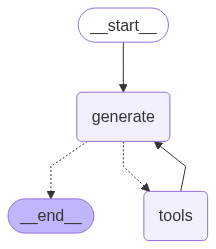

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [35]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="지금 노르웨이는 몇 시야?")]

gathered = None

for msg, metadata in graph.stream({"messages":inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end="")

        if gathered is None:
            gathered = msg
        else:
            gathered += msg

gathered

현재 노르웨이는 2025년 9월 3일 오후 3시 14분입니다.

AIMessageChunk(content='현재 노르웨이는 2025년 9월 3일 오후 3시 14분입니다.', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_PRG4XFjC3Cyit2DIUCzuXU7M', 'function': {'arguments': '{"timezone":"Europe/Oslo","location":"노르웨이"}', 'name': 'get_current_time'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_callsstop', 'model_name': 'gpt-4o-mini-2024-07-18gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2cfp_8bda4d3a2c', 'service_tier': 'defaultdefault'}, id='run--76da0ad0-3a97-4baa-8625-d0e745acaec7', tool_calls=[{'name': 'get_current_time', 'args': {'timezone': 'Europe/Oslo', 'location': '노르웨이'}, 'id': 'call_PRG4XFjC3Cyit2DIUCzuXU7M', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'get_current_time', 'args': '{"timezone":"Europe/Oslo","location":"노르웨이"}', 'id': 'call_PRG4XFjC3Cyit2DIUCzuXU7M', 'index': 0, 'type': 'tool_call_chunk'}])

#### 프롬프트 설정하고 기사 작성하기

In [36]:
from langchain_core.messages import AIMessageChunk, SystemMessage

about = "2025년 GOTY 전망"

inputs = [SystemMessage(content = f"""
너는 게임 전문 기자야.
최근 {about}에 대한 심층 분석 기사를 쓰려고 해.

- 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘.
- 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐. 
- 검색할 리스트를 토대로 재검색을 한다. 
- 목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해라.
- 검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋다. 

더 이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성하라.
제목, 부제, 리드문, 본문 의 구성으로 작성하라. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이 있게 작성해야 한다. 
""")]

for msg, metadata in graph.stream({"messages":inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end="")



----- WEB SEARCH -----
# Query: 2025 GOTY 전망
# Search Period: m
1. snippet: goty 2025 ... BAFTA Games Awards 2025 : Black Myth: Wukong repart bredouille, voici le GOTY ... Une nouvelle bataille pour le GOTY aura lieu le mois ..., title: goty 2025 - GAMERGEN.COM, link: https://gamergen.com/s/goty+2025
2. snippet: BAFTA Games Awards 2025 GOTY Jeu de l'année Meilleur jeu Prix Récompenses Jeux vidéo Anglais ASTRO BOT Balatro Black Myth Wukong Senua's Saga ..., title: BAFTA Games Awards 2025 : Black Myth: Wukong repart bredouille,, link: https://gamergen.com/actualites/bafta-games-awards-2025-black-myth-wukong-repart-bredouille-goty-339366-1
3. snippet: Quels sont alors les jeux les mieux placés pour décrocher le précieux titre de Jeu de l’Année, le GOTY 2025 ? Voici notre tour d ..., title: Prédictions pour le Jeu de l'Année GOTY 2025 : Les, link: https://www.kingofgeek.com/2025/05/predictions-jeu-de-l-annee-goty-2025/
4. snippet: Como era de esperar, especialmente tras ver a GTA: San And